# DBSCAN

# Library Imports

In [42]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
import sklearn.metrics as metrics
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from helpers import cust_func

%matplotlib inline
#plt.rcParams['figure.figsize'] = [16, 9]
plt.style.use("fivethirtyeight")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
digits = datasets.load_digits(as_frame = True)

In [3]:
X, y = digits.data, digits.target

In [4]:
X.head()

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_6,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0


In [5]:
y.head()

0    0
1    1
2    2
3    3
4    4
Name: target, dtype: int32

In [43]:
n_near = 28
nn_steps = [('scaler', MinMaxScaler()), ('pca', PCA(n_components=14)), ('nn', NearestNeighbors(n_neighbors=n_near))]
nn_pipe = Pipeline(nn_steps)
nn_pipe.fit(X)

Pipeline(steps=[('scaler', MinMaxScaler()), ('pca', PCA(n_components=14)),
                ('nn', NearestNeighbors(n_neighbors=28))])

In [53]:
distances, indices = nn_pipe['nn'].kneighbors(nn_pipe[:2].transform(X))
distances = np.sort(distances, axis=0)
distances = distances[:,1]

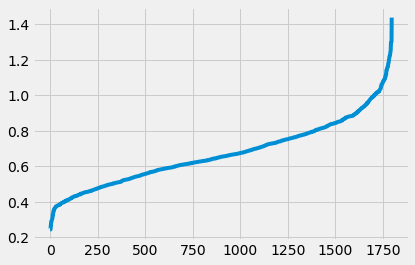

In [54]:
plt.plot(distances)

In [75]:
dbscan_steps = [('scaler', MinMaxScaler()), ('pca', PCA(n_components=14)), ('dbscan', DBSCAN(eps=1.12, min_samples=n_near))] #1.4 10 #1.05 10
dbscan = Pipeline(dbscan_steps)
dbscan.fit(X) 

Pipeline(steps=[('scaler', MinMaxScaler()), ('pca', PCA(n_components=14)),
                ('dbscan', DBSCAN(eps=1.12, min_samples=28))])

In [76]:
labels = dbscan['dbscan'].labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 10
Estimated number of noise points: 630


In [77]:
classified = labels != -1
outliers = labels == -1
core = dbscan['dbscan'].core_sample_indices_
non_core = np.full(len(labels), True)
non_core[core] = False
non_core[outliers] = False

In [78]:
pca_pipe = dbscan[:2]
fscores = pca_pipe.fit_transform(X)
np.cumsum(pca_pipe["pca"].explained_variance_ratio_)

array([0.14815157, 0.28338833, 0.40045486, 0.48362011, 0.54098624,
       0.58948714, 0.63201594, 0.66879108, 0.70202483, 0.73249112,
       0.75608631, 0.77890892, 0.79712096, 0.81483914])

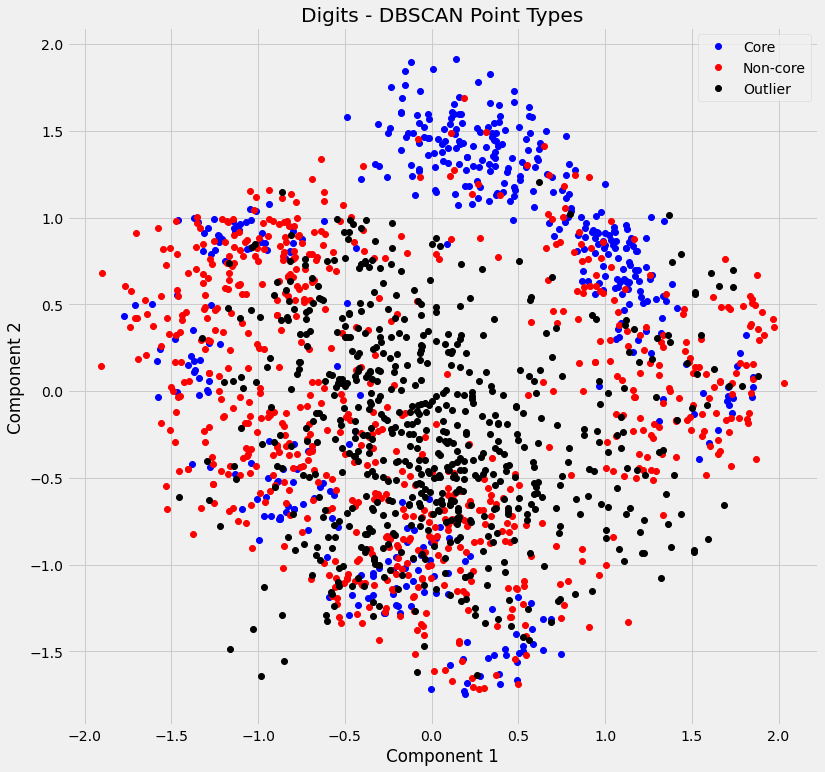

In [79]:
fig, ax = plt.subplots(figsize=(12,12))
ax.plot(fscores[core, 0],
        fscores[core, 1],
        "bo",
        label="Core")
ax.plot(fscores[non_core, 0],
        fscores[non_core, 1],
        "ro",
        label="Non-core")
ax.plot(fscores[outliers, 0],
        fscores[outliers, 1],
        "ko",
        label="Outlier")
ax.set_aspect('equal')
ax.set_title("Digits - DBSCAN Point Types")
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.legend()
plt.show()

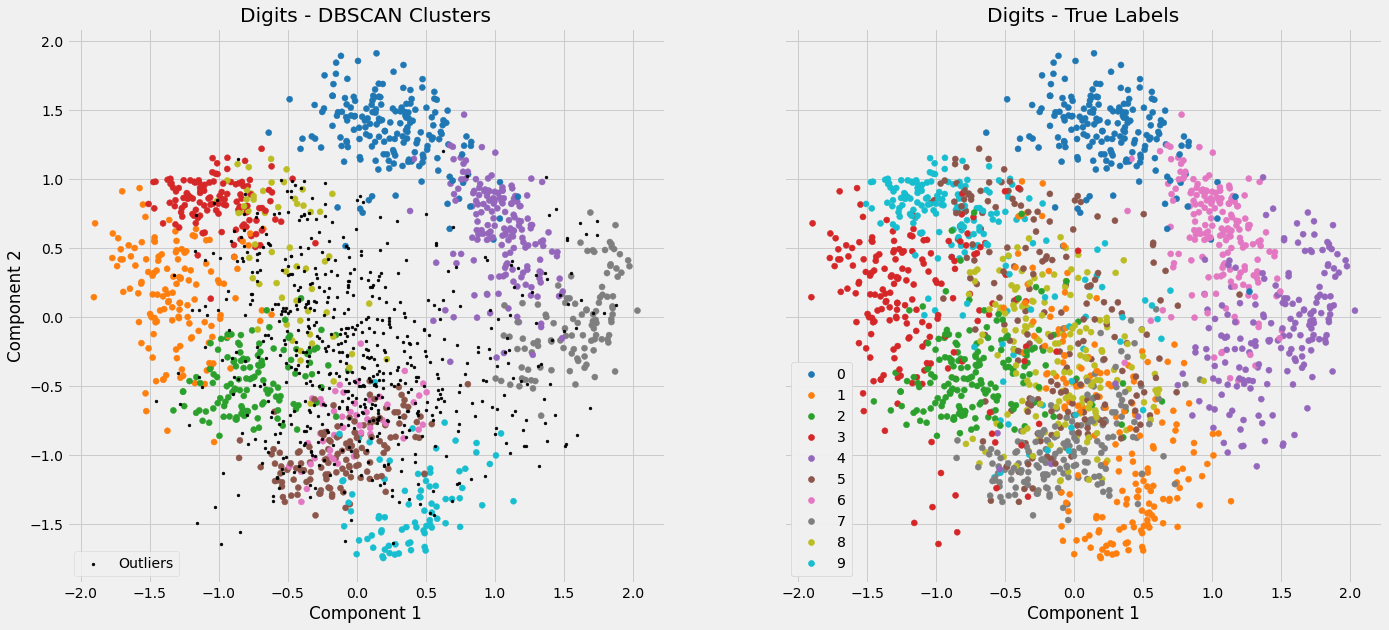

In [80]:
# Plot fscores for first two components
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (21, 12), sharey=True)
#plt.figure(figsize=(12, 12))
ax1.scatter(fscores[classified, 0], fscores[classified, 1],
            c=labels[classified], cmap=plt.cm.get_cmap('tab10', n_clusters_))
ax1.scatter(fscores[outliers, 0], fscores[outliers, 1],
            s=8,
            c="black",
            label="Outliers")
sc2 = ax2.scatter(fscores[:, 0], fscores[:, 1],
            c=y, cmap=plt.cm.get_cmap('tab10', 10),
            )

#ax = sc.axes
ax1.set_aspect('equal')
ax1.set_title("Digits - DBSCAN Clusters")
ax1.set_xlabel("Component 1")
ax1.set_ylabel("Component 2")
ax1.legend(loc="lower left")
ax2.set_aspect('equal')
ax2.set_title("Digits - True Labels")
ax2.set_xlabel("Component 1")
legend2 = ax2.legend(*sc2.legend_elements())
ax2.add_artist(legend2)

plt.show()